In [4]:
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.dates 
import datetime 

train = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/train.csv')
store = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/store.csv')
test = pd.read_csv('/content/drive/MyDrive/Pharmaceutical_Sales_prediction/data/test.csv') 

store.head()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


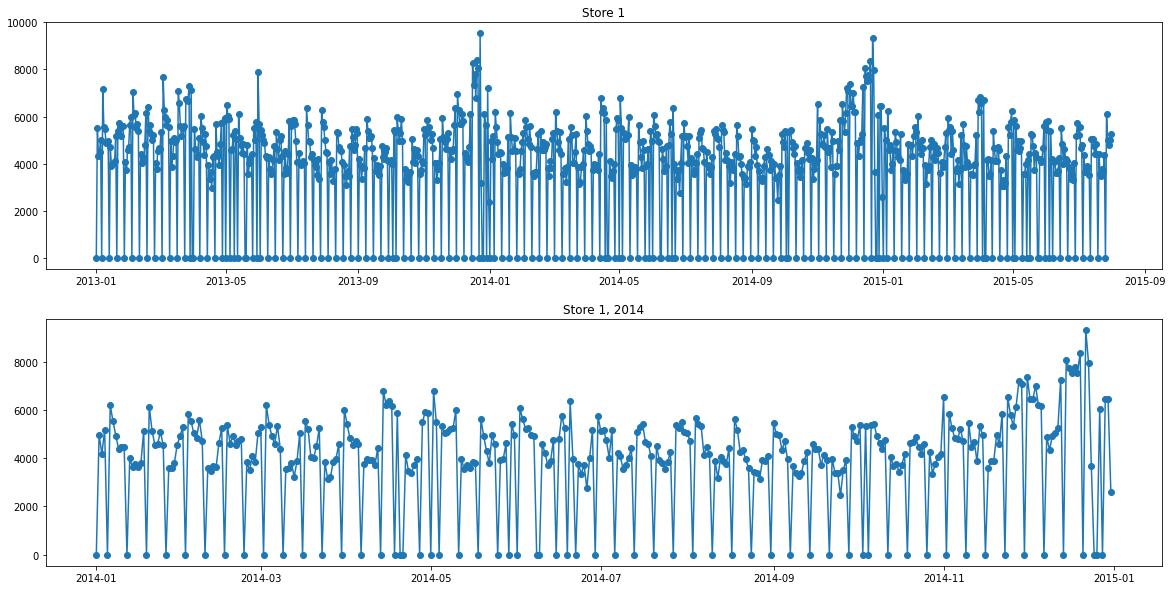

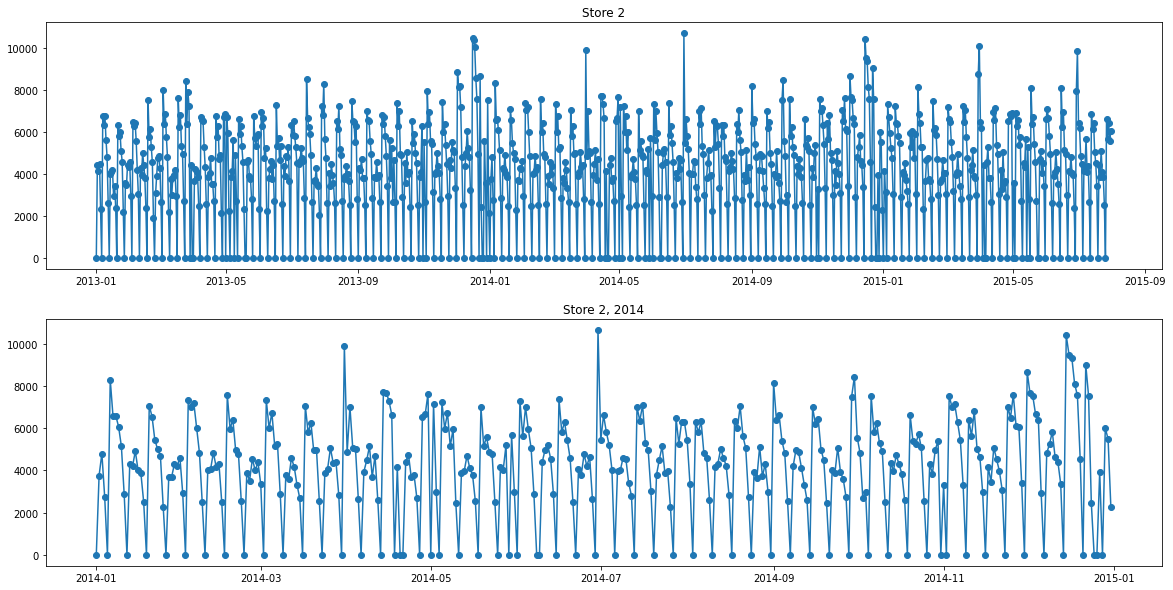

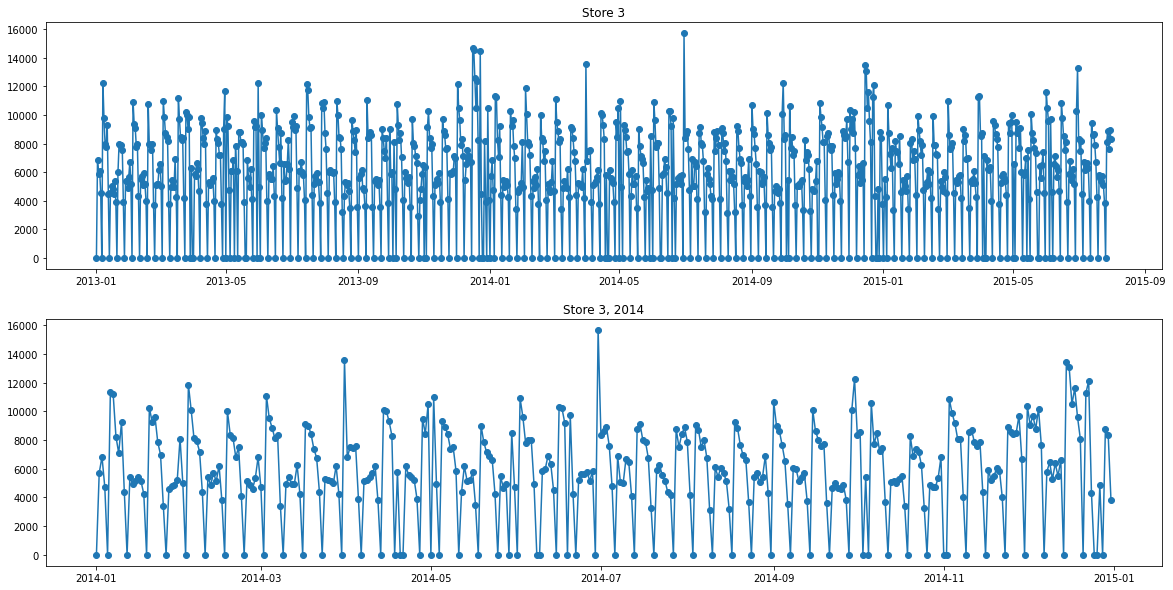

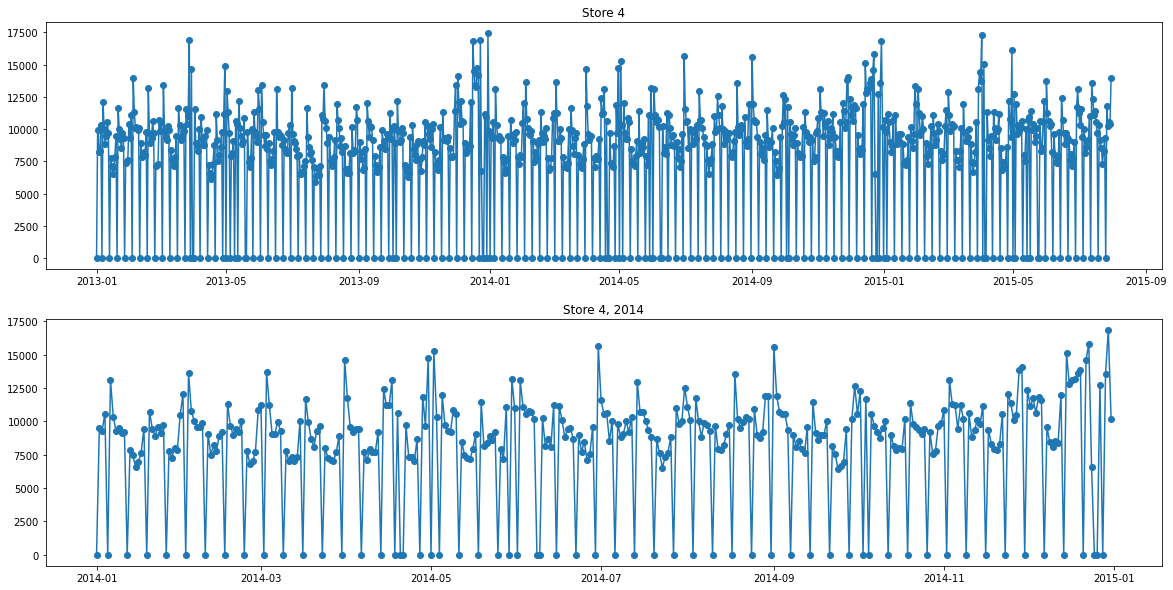

In [10]:
## transform date variable
datetimes = [datetime.datetime.strptime(t, "%Y-%m-%d") for t in train.Date]
plotData = matplotlib.dates.date2num(datetimes) 
train = train.join(pd.DataFrame(plotData,columns = ['datetimes']))
def splitTime(x): 
    mysplit = datetime.datetime.strptime(x,  "%Y-%m-%d") 
    return [mysplit.year,mysplit.month,mysplit.day]
train = train.join(pd.DataFrame(train.Date.apply(splitTime).tolist(), columns = ['year','mon','day']))

# plot the first 5 stores sales vs time

for i in range(1,5):
 plt.figure(i,figsize=(20,10)) 
 plt.subplot(211)
 plt.plot_date(train.loc[train.Store==i,'datetimes'],train.loc[train.Store==i,'Sales'],linestyle='-') 
 plt.title('Store %d' %i)  
 plt.subplot(212)
 train2014 = train.loc[train.year == 2014,:]
 plt.plot_date(train2014.loc[train2014.Store==i,'datetimes'],train2014.loc[train2014.Store==i,'Sales'],linestyle='-') 
 plt.title('Store %d, 2014' %i)  
 plt.show()

Text(0.5, 1.0, 'Distribution of log(Sales)')

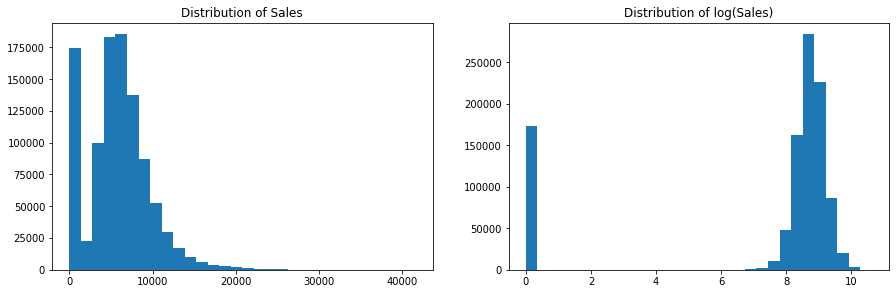

In [11]:

## distribution of sales variable
plt.figure(1,figsize=(15,10)) 
plt.subplot(221)
plt.hist(train.Sales,bins=30)
plt.title("Distribution of Sales") 
plt.subplot(222)
plt.hist(np.log(train.Sales+1),bins=30)
plt.title("Distribution of log(Sales)") 

(array([  3.,   6.,  10.,  11.,  23.,  25.,  48.,  62.,  82.,  85., 103.,
        101., 119., 107.,  79.,  75.,  57.,  36.,  30.,  13.,   7.,  11.,
          5.,   5.,   2.,   5.,   1.,   1.,   2.,   1.]),
 array([7.71623948, 7.79032426, 7.86440905, 7.93849384, 8.01257862,
        8.08666341, 8.1607482 , 8.23483298, 8.30891777, 8.38300255,
        8.45708734, 8.53117213, 8.60525691, 8.6793417 , 8.75342649,
        8.82751127, 8.90159606, 8.97568085, 9.04976563, 9.12385042,
        9.1979352 , 9.27201999, 9.34610478, 9.42018956, 9.49427435,
        9.56835914, 9.64244392, 9.71652871, 9.7906135 , 9.86469828,
        9.93878307]),
 <a list of 30 Patch objects>)

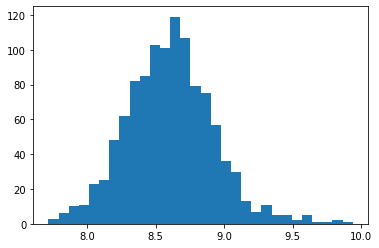

In [12]:
plt.hist([np.log(train.groupby('Store').Sales.mean()) ],bins=30)

In [13]:
toAppend = pd.DataFrame(np.log(train.Sales+1),dtype=float)
toAppend.columns.values[0]='LogSale'
train=train.join(toAppend)
train.dtypes

Store              int64
DayOfWeek          int64
Date              object
Sales              int64
Customers          int64
Open               int64
Promo              int64
StateHoliday      object
SchoolHoliday      int64
datetimes        float64
year               int64
mon                int64
day                int64
LogSale          float64
dtype: object

In [14]:
### data transformation on store data set

## transform variable PromoInterval to 12 dummy variables
def myPinterval(x):
    if x=='Feb,May,Aug,Nov':  return([0,1,0,0,1,0,0,1,0,0,1,0])
    elif x=='Jan,Apr,Jul,Oct':  return([1,0,0,1,0,0,1,0,0,1,0,0])
    elif x== 'Mar,Jun,Sept,Dec': return([0,0,1,0,0,1,0,0,1,0,0,1])
    else: return(np.repeat(0,12).tolist())

proInt = store.PromoInterval.apply(myPinterval).tolist()
proInt = pd.DataFrame(proInt, columns = ['ProInt'+ str(i) for i in range(1,13)])
store = store.drop('PromoInterval',1).join(proInt)

store = store.drop('StoreType',1).join(pd.get_dummies(store['StoreType']).rename(columns=lambda x: 'StoreType' +"_"+str(x)))  
store = store.drop('Assortment',1).join(pd.get_dummies(store['Assortment']).rename(columns=lambda x: 'Assortment' +"_"+str(x))) 

In [15]:
##assume 0 and '0' are the same in train.StateHoliday 
def mychange(x):
     if type(x)!= str: x=str(x)
     return x
        
train.StateHoliday = [mychange(x) for x in train.StateHoliday]

newtrain = train.drop('StateHoliday',1).join(pd.get_dummies(train['StateHoliday']).rename(columns=lambda x: 'StateHoliday' +"_"+str(x)))

In [16]:
## merge training set with store

newtrain=pd.merge(newtrain, store, on="Store")  
newtrain.drop(['Date','Customers','datetimes','Sales'],axis = 1,inplace=True)

In [18]:
## do the same thing on testing set
test = test.join(pd.DataFrame(test.Date.apply(splitTime).tolist(), columns = ['year','mon','day']))
newtest = test.drop('StateHoliday',1).join(pd.get_dummies(test['StateHoliday']).rename(columns=lambda x: 'StateHoliday' +"_"+str(x)))  
newtest = pd.merge(newtest,store, on="Store")
newtest.drop(['Date'],axis = 1,inplace=True) 

ValueError: ignored

In [19]:
## check if there exists any constant variable
np.sum(newtrain.var()==0)

0

In [ ]:
!pip install sklearn

Feature ranking:
1. feature 2 :Open (0.985945)
2. feature 10 :StateHoliday_b (0.002814)
3. feature 3 :Promo (0.002242)
4. feature 0 :Store (0.001968)
5. feature 1 :DayOfWeek (0.001030)
6. feature 12 :CompetitionDistance (0.000976)
7. feature 7 :day (0.000824)
8. feature 11 :StateHoliday_c (0.000771)
9. feature 6 :mon (0.000725)
10. feature 15 :Promo2 (0.000549)
11. feature 14 :CompetitionOpenSinceYear (0.000375)
12. feature 5 :year (0.000289)
13. feature 32 :StoreType_c (0.000281)
14. feature 28 :ProInt11 (0.000247)
15. feature 29 :ProInt12 (0.000227)
16. feature 30 :StoreType_a (0.000116)
17. feature 31 :StoreType_b (0.000115)
18. feature 4 :SchoolHoliday (0.000084)
19. feature 21 :ProInt4 (0.000043)
20. feature 24 :ProInt7 (0.000040)
21. feature 18 :ProInt1 (0.000039)
22. feature 27 :ProInt10 (0.000039)
23. feature 13 :CompetitionOpenSinceMonth (0.000032)
24. feature 34 :Assortment_a (0.000027)
25. feature 22 :ProInt5 (0.000025)
26. feature 25 :ProInt8 (0.000025)
27. feature 19 :ProI

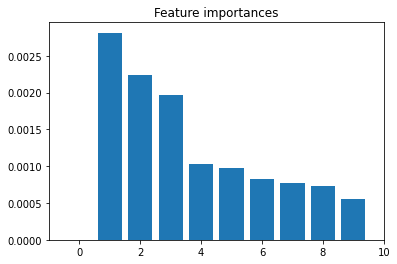

In [28]:
##### randomforest
from sklearn.ensemble import RandomForestRegressor

##### delete variables that do not exist in the test set
toDrop = list(set(newtrain.columns.values)-set(newtest.columns.values) )
features = newtrain.columns.drop(toDrop,1)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(newtrain.drop(toDrop ,1).fillna(-1),newtrain.LogSale)


importances = rf.feature_importances_ 
# return the indices that would sort the importance, decreasing
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


Features = newtrain.columns.drop('LogSale')
for f in range(35):
    print("%d. feature %d :%s (%f)" % (f + 1, indices[f],Features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
# the most important feature 'open' is left out in the plot to make it easier to see the other features
plt.figure()
plt.title("Feature importances")
plt.bar(range(1,10), importances[indices[range(1,10)]]) 
plt.xlim([-1, 10])
plt.show()

# make prediction on test data
mypred = rf.predict(newtest.drop('Id',1).fillna(-1))